In [1]:
%matplotlib inline
import matplotlib.pyplot as pyplot

from datetime import datetime, timedelta

import numpy 
import summary

from numpy.random import random
from numpy import pi, exp, log, arccos, sin, cos

from frame import summation_shift, transformation_shift

from plot import enable_seaborn
seaborn = enable_seaborn()

from scipy import interpolate
import voronoi
import basic

from summary import weighted_mean, weighted_std

import monte_carlo
from monte_carlo import UniformAngleSampling, UniformAreaSampling
# from monte_carlo import InverseSquareSampling, ExponentialSampling

import pandas

numpy.set_printoptions(precision=4, suppress=False)


@numpy.vectorize
def fractional_year(year):
    """
    Adapted from
    http://stackoverflow.com/questions/20911015/decimal-years-to-datetime-in-python
    """
    whole_year = int(year)
    fraction = year - whole_year
    this_year = datetime(whole_year, 1, 1)
    next_year = datetime(whole_year + 1, 1, 1)
    in_seconds = fraction * (next_year - this_year).total_seconds()
    
    return this_year + timedelta(seconds=in_seconds)

def cumulative_mean(u, N):
    """
    Unweighted mean.
    """
    cs = numpy.cumsum(u, axis=0)
    M = numpy.array([numpy.arange(N) + 1]).T
    return cs / M

def cumulative_std(u, N):
    """
    Unweighted stddev.
    """
    mean = cumulative_mean(u, N)
    X = u
    css = numpy.cumsum(u * u, axis=0)
    M = numpy.array([numpy.arange(N) + 1]).T
    diff = css / M - mean ** 2
    result = numpy.sqrt(diff)        
    return result

def sandwich(means, stds, skip=0):
    def single(means, stds, component, axis):
        c = component
        roll = numpy.arange(means.shape[1])
        axis.plot(roll, means[c, :], 'r',
                    roll, means[c, :] + stds[c, :], 'g',
                    roll, means[c, :] - stds[c, :], 'g')
        axis.set_title('$\mu = {:.5f}$, $\quad$ $\sigma = {:.5f}$'
                     .format(means[c, -1], stds[c, -1]))

    fig, axes = pyplot.subplots(3, figsize=(10, 9),
                                sharex=True,
                                sharey=True)
    
    for i in range(3):
        single(means[:, skip:].real, stds[:, skip:].real, i, axes[i])


def sections(tally, milestones, axis=1):
    trials = tally.shape[-1]
    if len(tally.shape) == 2:
        vector = True
        axis = 0
    else:
        vector = False
    
    x_vals = []
    y_vals = []
    dy_vals = []
    
    for mile in milestones:
        if mile < trials:
            x_vals.append(mile)
            vals = tally[..., :mile]
            y_vals.append(vals.mean(axis=axis))
            dy_vals.append(vals.std(axis=axis))
    
    x_vals = numpy.array(x_vals)
    y_vals = numpy.array(y_vals).T
    dy_vals = numpy.array(dy_vals).T
    
    if vector:
        fig, axes = pyplot.subplots(3, 1,figsize=(5, 6))
        for component in range(3):
            axes[component].plot(x_vals, y_vals[component], 'r',
                                 x_vals, (y_vals + dy_vals)[component], 'g',
                                 x_vals, (y_vals - dy_vals)[component], 'g')
    else:
        fig, axes = pyplot.subplots(1, 1, figsize=(5, 6))
        maxi = numpy.max(y_vals)
        pyplot.ylim((maxi / 2., 3 * maxi / 2.))
        axes.plot(x_vals, y_vals, 'r')


In [35]:
time, N, E, U, dN, dE, dU = numpy.loadtxt('../data/sopac/raw/brasr.neu', unpack=True)

/home/zannat/anaconda2/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


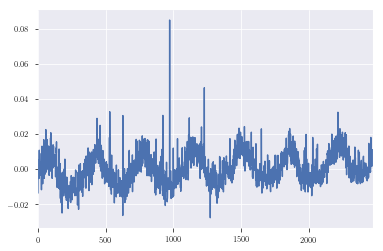

In [36]:
seaborn.tsplot(U)

## plain Monte Carlo

In [2]:
N = 9
folder = "../data/bigger/dc-1/10/"
options = summary.read_options(folder)
radius_in_cm = options['model']['radius'] * 1.e+5    # in cm
field = summary.binary_to_field(folder)
u = field.interpolate(options)
print 'origin', options['shift']['origin']
print '   EOP', options['shift']['EOP']
trials = 5000

origin [0.18535883009756288, 0.0, 0.0]
   EOP [0.0, 89.81268617860457, 0.0]


## importance sampling

In [105]:
%%time
sampling = InverseSquareSampling(N, theta_0=pi/10.)
tally = sampling.collect(trials, u, summation_shift,
                         radius_in_cm)
monte_carlo.print_stats(tally)

 T mean (mm) [ 0.64    0.263   0.0158]
 T  std (mm) [ 107.2038   37.4501  109.4439] (157.712146115)
R mean (μas) [-12.7833  31.0944  -0.0318]
R  std (μas) [  1.8157e+03   5.1990e+03   1.7913e+00] (5506.93072277)
CPU times: user 1min 6s, sys: 80 ms, total: 1min 6s
Wall time: 1min 6s


CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 316 ms


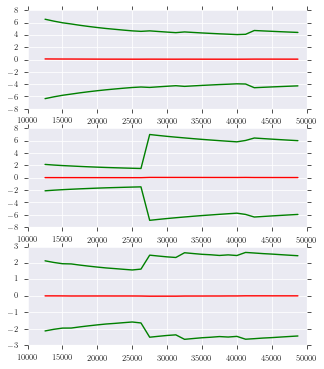

In [106]:
%%time
sections(tally['T'] * tally['W'], 
         range(trials / 4, trials, trials / 40))

CPU times: user 304 ms, sys: 0 ns, total: 304 ms
Wall time: 319 ms


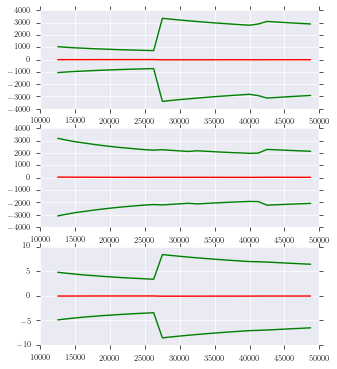

In [107]:
%%time
sections(tally['R'] * tally['W'], 
         range(trials / 4, trials, trials / 40))

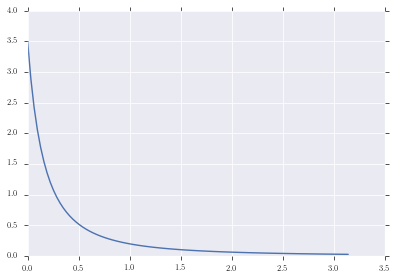

In [110]:
sampling = InverseSquareSampling(N, theta_0=pi/10)
theta = numpy.linspace((0./80.) * pi, numpy.pi, 100)
pdf = sampling.pdf_theta(theta)
uu = numpy.array([u(th, 0)[0] for th in theta])
pyplot.plot(theta, pdf)

# verification of importance sampling

In [55]:
%%time

for counter in range(5):

    N = 25

    BATCH = 1000
    TOLERANCE = 0.05
    PARAM = 50
    mean = []

    values = numpy.array([[], [], []])
    weights = numpy.array([])

    sampling = InverseSquareSampling(N, theta_0=pi / 2.)
    #sampling = UniformAngleSampling(N)

    while True:
        tally = sampling.collect(BATCH, u, summation_shift, radius_in_cm)
        y = tally['T']
        w = tally['W']

        values = numpy.concatenate((values, y),axis=1)
        weights = numpy.concatenate((weights, w))

        mean.append((values * weights).mean(axis=1))

        try:
            last = mean[-1]
            converged = True
            for i in range(PARAM):
                diff = last - mean[i - PARAM]
                if numpy.linalg.norm(diff) > TOLERANCE:
                    converged = False
                    break
            if converged:
                break
        except:
            pass

    mean = numpy.array(mean) 
    print "#", mean[-1], mean.shape

# [ 0.05   -0.0119 -0.0187] (67, 3)
# [ 0.2636 -0.1595 -0.198 ] (381, 3)
# [ 0.1794  0.0184  0.1316] (175, 3)
# [ 0.2093 -0.0615  0.1269] (269, 3)
# [ 0.0884  0.0248 -0.0253] (79, 3)
CPU times: user 1h 1min 36s, sys: 1.15 s, total: 1h 1min 37s
Wall time: 1h 1min 52s


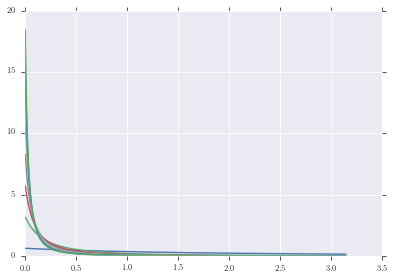

In [51]:
theta = numpy.linspace(0, pi, 1000)
for i in range(1, 64, 8):
    sample = InverseSquareSampling(N=10000, theta_0 = pi / i)
    pdf = sample.pdf_theta(theta)
    
    pyplot.plot(theta, pdf)
    

In [ ]:
# N = 25 (batch 500, tol 0.01)
# uniform angle
# [ 0.1831  0.0201  0.021 ] (239, 3)
# [ 0.1929  0.0036 -0.0195] (327, 3)
# [ 0.2196 -0.0189 -0.0588] (239, 3)
# [ 0.1815 -0.0079 -0.0332] (235, 3)
# [ 0.1573  0.0125  0.0043] (240, 3)
# total: 44min 56s
#
# inverse square (pi/2) (batch 1000, tol 0.05)

In [1]:
# N = 1
# uniform angle 298, 225 342 282 322
# inverse square (pi/4) 173 143 167 155 168
# inverse square (pi/16) 121 113 129 118 120

# N = 5
# uniform angle 118 (0.197)
#               116 (0.183)
#               118 (0.197)
#               107 (0.177)
#               131 (0.188)
# inverse square (pi/4)
# [ 0.1939  0.0084  0.0135] (178, 3)
# [ 0.1951  0.0115 -0.0146] (140, 3)
# [ 0.1955  0.0008  0.0011] (158, 3)
# [ 0.1909 -0.0025 -0.0037] (183, 3)
# [ 0.1975 -0.0148  0.0343] (155, 3)

# inverse square (pi/16) 299 (0.1729) 
#                        328 (0.1893)
#                        235 (0.166a7)
#                        385 (0.1902)
#                        342 (0.2021)
# 


## comparison with half-space

In [2]:
%matplotlib inline
from matplotlib import pyplot

import numpy
from numpy import sin, cos, sqrt, pi, array, radians, log10

from earth import earth_radius as radius
from basic import angular_to_cartesian as cartesian
import summary

numpy.set_printoptions(precision=4, suppress=True)

# in units of Pa
mu = 2.6 * (10 ** 10)
kappa = 5.2 * (10 ** 10)
lamda = kappa - 2. * mu / 3.

# without units
zhat = array([0, 0, 1])

def moment_magnitude(scalar_moment):
    # scalar moment is in N m
    M0 = scalar_moment * 10 ** 7
    return 2. * log10(M0) / 3. - 10.7


def plane_to_sphere(x, y):
    theta = sqrt(x ** 2 + y ** 2) / radius
    phi = numpy.arctan2(y, x)
    
    return theta, phi


class Okada(object):
    def __init__(self, point, d, delta):
        self.point = point
        self.d = d
        self.delta = delta

        x, y, z = point
        self.p = y * cos(delta) + self.d * sin(delta)
        self.q = y * sin(delta) - self.d * cos(delta)        
        self.R = sqrt(x ** 2 + y ** 2 + d ** 2)
        R = self.R
        
        coeff = mu / (lamda + mu)
        first = 1 / (R * (R + d) ** 2)
        second = (3 * R + d) / (R ** 3 * (R + d) ** 3)
        third = (2 * R + d) / (R ** 3 * (R + d) ** 2)
        fourth = 1 / (R * (R + d))
        
        self.I_1 = coeff * y * (first - x**2 * second)
        self.I_2 = coeff * x * (first - y**2 * second)
        self.I_3 = coeff * (x / R ** 3) - self.I_2
        self.I_4 = coeff * (-x * y * third)
        self.I_5 = coeff * (fourth - x ** 2 * third)
        
    def strike_slip(self):
        x, y, z = self.point
        q, R, d = self.q, self.R, self.d * numpy.ones_like(x)
        delta = self.delta
        I_1, I_2, I_4 = self.I_1, self.I_2, self.I_4
        
        return -(3. * x * q * array([x, y, d]) / R ** 5 +
                 array([I_1, I_2, I_4]) * sin(delta)) / (2. * pi) 
    
    def dip_slip(self):
        x, y, z = self.point
        q, R, d, p = self.q, self.R, self.d * numpy.ones_like(x), self.p
        delta = self.delta
        I_1, I_3, I_5 = self.I_1, self.I_3, self.I_5
        return -((3. * p * q * array([x, y, d]) / R ** 5 -
                 array([I_3, I_1, I_5]) * sin(delta) * cos(delta)) /
                 (2. * pi))
    
    def tensile_slip(self):
        x, y, z = self.point
        q, R, d = self.q, self.R, self.d * numpy.ones_like(x)
        delta = self.delta
        I_1, I_3, I_5 = self.I_1, self.I_3, self.I_5

        return (3. * q ** 2 * array([x, y, d]) / R ** 5 -
                 array([I_3, I_1, I_5]) * sin(delta) ** 2) / (2. * pi) 


In [3]:
# in degrees
delta = 0.

# in m
d = 10000

# in m
delta_u = 136.5 /sqrt(2)
L = 100000
W = 100000
Sigma = L * W

moment = mu * delta_u * Sigma * sqrt(2)

scale = 20000

x, y = numpy.meshgrid(numpy.linspace(-scale, scale, 100), 
                      numpy.linspace(-scale, scale, 100))

z = numpy.zeros_like(x)

theta, phi = plane_to_sphere(x, y)
phi[phi < 0] += 2. * numpy.pi 

In [4]:
okada = Okada(array([x, y, z]), d, radians(delta))

0
150
300
450
600
750
900


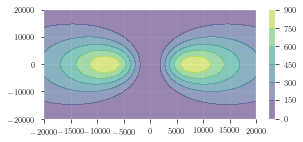

In [38]:
from matplotlib.ticker import FuncFormatter, MultipleLocator
formatter = FuncFormatter(lambda x, ps: r"{0:g}\,km".format(x / 1000))
fig, axes = pyplot.subplots(1, 1, figsize=(4.75,2), sharey=True)
ux, uy, uz = (delta_u * Sigma) * okada.strike_slip()
CS = axes.contourf(x, y, ux, cmap='viridis', alpha=0.5)
for tick in axes.get_yticklabels():
    break
font = tick.get_font_properties()
cb = pyplot.colorbar(CS)
for tick in cb.ax.get_yticklabels():
    tick.set_text(tick.get_text().strip('$'))
    print(tick.get_text())

In [22]:
font.get_family()

[u'sans-serif']

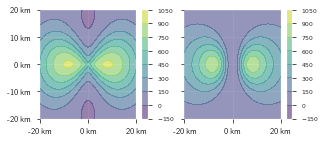

In [63]:
from matplotlib.ticker import FuncFormatter, MultipleLocator

formatter = FuncFormatter(lambda x, ps: r"{0:g}\,km".format(x / 1000))

fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2), sharey=True)

folder = '../data/bigger/dc-1/10/'
options = summary.read_options(folder)

field = summary.binary_to_field(folder)

u = field.interpolate(options)

ux = array([[u(theta[i, j], phi[i, j])[0] for j in range(theta.shape[1])] 
                for i in range(theta.shape[0])]) / 100

axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(MultipleLocator(20000))
axes[0].yaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(MultipleLocator(20000))

CS = axes[0].contourf(x, y, ux, cmap='viridis', alpha=0.5)
for tick in axes[0].get_yticklabels():
    break
font = tick.get_font_properties()

cb = pyplot.colorbar(CS, ax=axes[0])
for tick in cb.ax.get_yticklabels():
    tick.set_usetex(False)
    tick.set_fontsize(6)
    

ux, uy, uz = (delta_u * Sigma) * okada.strike_slip()
axes[1].xaxis.set_major_locator(MultipleLocator(20000))
axes[1].xaxis.set_major_formatter(formatter)
CS = axes[1].contourf(x, y, ux, CS.levels, cmap='viridis', alpha=0.5)
cb = pyplot.colorbar(CS, ax=axes[1])
for tick in cb.ax.yaxis.get_ticklabels():
    tick.set_usetex(False)
    tick.set_fontsize(6)

pyplot.savefig('figures/thesis-okada.pdf', bbox_inches='tight')


In [53]:
font.get_style()

u'normal'

In [29]:
tick.get_label()

u''

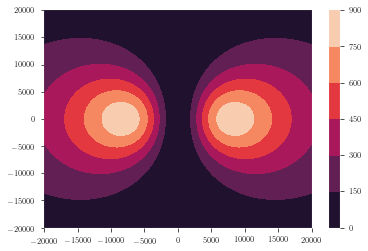

In [37]:
ux, uy, uz = (delta_u * Sigma) * okada.strike_slip()
CS = pyplot.contourf(x, y, ux)
pyplot.colorbar(CS)

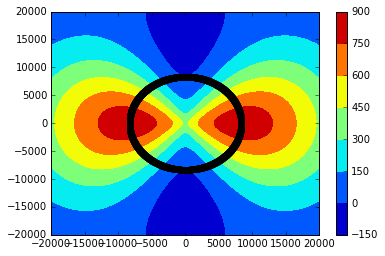

In [6]:
folder = '../data/okada'
options = summary.read_options(folder)

field = summary.binary_to_field(folder)

u = field.interpolate(options)

ux = array([[u(theta[i, j], phi[i, j])[0] for j in range(theta.shape[1])] 
                for i in range(theta.shape[0])]) / 100

CS = pyplot.contourf(x, y, ux)
pyplot.colorbar(CS)

field_theta = field.theta[field.theta < .002]
field_phi = field.phi[field.theta < .002]

field_x = field_theta * radius * cos(field_phi)
field_y = field_theta * radius * sin(field_phi)

pyplot.plot(field_x, field_y, 'ko')

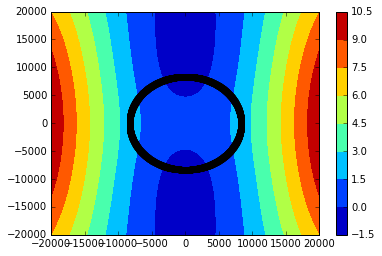

In [7]:
folder = '../data/bigger/dc-1/50/'
options = summary.read_options(folder)

field = summary.binary_to_field(folder)

u = field.interpolate(options)

ux = array([[u(theta[i, j], phi[i, j])[0] for j in range(theta.shape[1])] 
                for i in range(theta.shape[0])]) / 100

field_theta = field.theta[field.theta < .002]
field_phi = field.phi[field.theta < .002]

field_x = field_theta * radius * cos(field_phi)
field_y = field_theta * radius * sin(field_phi)

CS = pyplot.contourf(x, y, ux)
pyplot.colorbar(CS)

pyplot.plot(field_x, field_y, 'ko')

## Okada figure for thesis